In [1]:
pip install skforecast

In [2]:
pip install skforecast==0.10.1

In [3]:
pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master

  Cloning https://github.com/JoaquinAmatRodrigo/skforecast to /tmp/pip-req-build-7tme35f9
  Running command git clone --filter=blob:none --quiet https://github.com/JoaquinAmatRodrigo/skforecast /tmp/pip-req-build-7tme35f9
  Resolved https://github.com/JoaquinAmatRodrigo/skforecast to commit db04f762d878c096b87b97de1a20f35025bbc437
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
pip install skforecast[full]

In [5]:
pip install skforecast[sarimax]

In [6]:
pip install skforecast[plotting]

In [7]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [8]:
df = pd.read_csv('vic_elec.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [9]:
# Carga los datos del archivo CSV en un DataFrame
datostodo = df

half_length = len(datostodo) // 2
datos = datostodo.iloc[:half_length].copy()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
datos.shape

(26304, 5)

In [11]:
datos.head()

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [12]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()
datos.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


In [13]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [14]:
print(f"Filas con missing values: {datos.isnull().any(axis=1).mean()}")


Filas con missing values: 0.0


In [15]:
# Completar huecos en un índice temporal
# ==============================================================================
datos.asfreq(freq='30min', fill_value=np.nan)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2013-07-01 10:30:00,5289.531748,13.60,2013-07-01,False
2013-07-01 11:00:00,5095.421130,14.10,2013-07-01,False
2013-07-01 11:30:00,4874.517356,14.30,2013-07-01,False


In [16]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2013-07-01 09:00:00,6044.907564,13.950,0.0
2013-07-01 10:00:00,5691.759812,13.700,0.0
2013-07-01 11:00:00,5366.529801,13.500,0.0


In [17]:
# Separación datos train-val-test
# ==============================================================================

datos = datos.loc['2011-12-31 14:00:00': '2013-07-01 13:00:00'].copy()
fin_train = '2012-12-31 01:59:00'
fin_validacion = '2013-06-16 01:59:00'

# Realizar la división
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()


print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2011-12-31 14:00:00 --- 2012-12-31 01:00:00  (n=8772)
Fechas validacion : 2012-12-31 02:00:00 --- 2013-06-16 01:00:00  (n=4008)
Fechas test       : 2013-06-16 02:00:00 --- 2013-07-01 13:00:00  (n=372)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

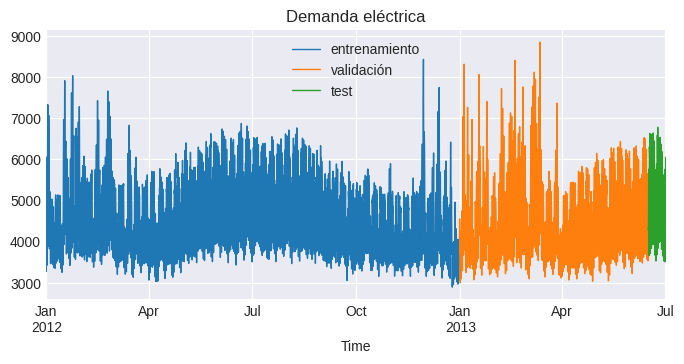

In [18]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


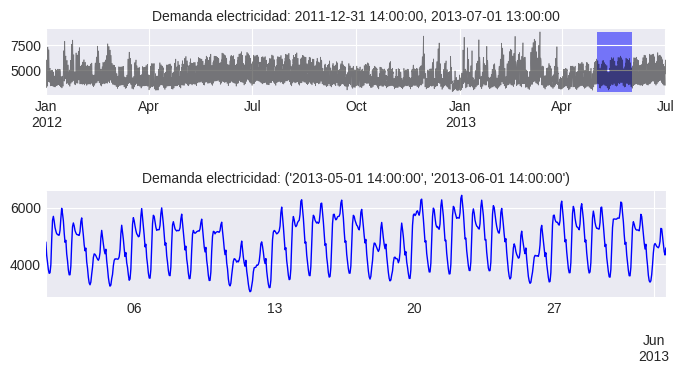

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [19]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=10)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


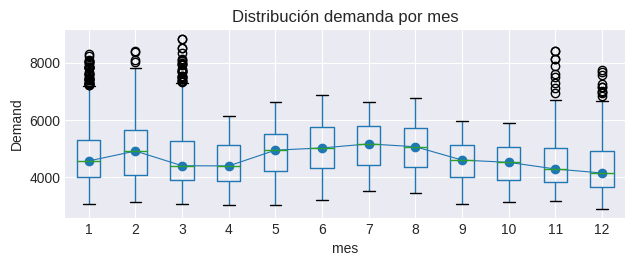

In [20]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


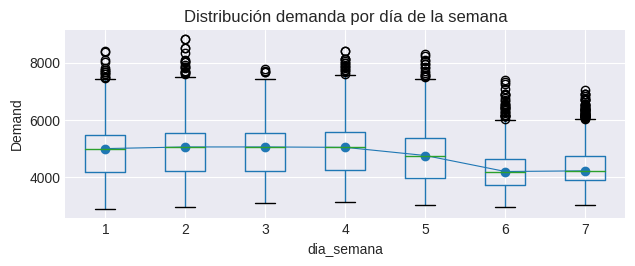

In [21]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


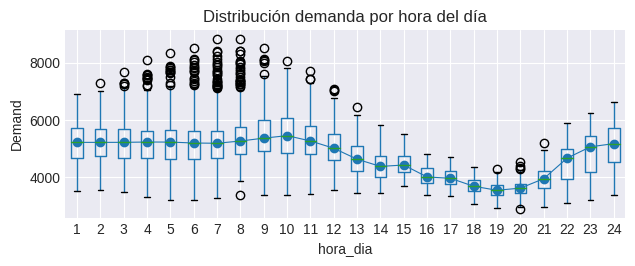

In [22]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


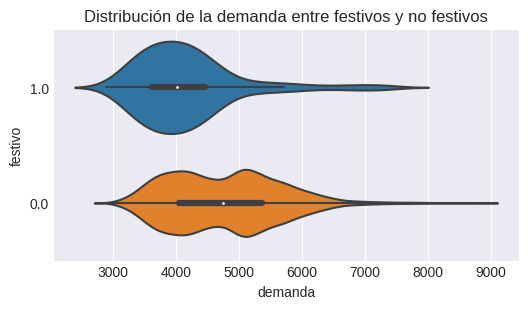

In [23]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


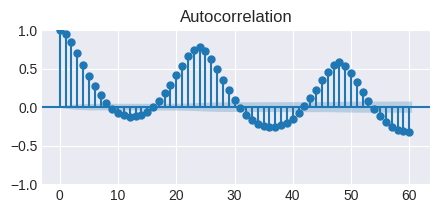

In [24]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(datos.Demand, ax=ax, lags=60)
plt.show()

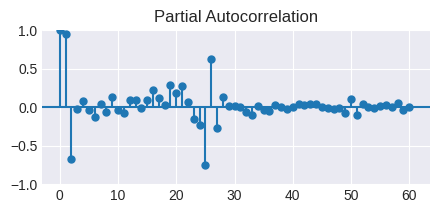

In [25]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(datos.Demand, ax=ax, lags=60)
plt.show()

In [26]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2011-12-31 14:00:00'), Timestamp('2013-06-16 01:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-26 15:38:45 
Last fit date: 2023-10-26 15:38:45 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [27]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['Demand'],
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = True,
                            show_progress      = True
                        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 12780
Number of observations used for backtesting: 372
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 12 observations.

Fold: 0
    Training:   2011-12-31 14:00:00 -- 2013-06-16 01:00:00  (n=12780)
    Validation: 2013-06-16 02:00:00 -- 2013-06-17 01:00:00  (n=24)
Fold: 1
    Training:   2011-12-31 14:00:00 -- 2013-06-16 01:00:00  (n=12780)
    Validation: 2013-06-17 02:00:00 -- 2013-06-18 01:00:00  (n=24)
Fold: 2
    Training:   2011-12-31 14:00:00 -- 2013-06-16 01:00:00  (n=12780)
    Validation: 2013-06-18 02:00:00 -- 2013-06-19 01:00:00  (n=24)
Fold: 3
    Training:   2011-12-31 14:00:00 -- 2013-06-16 01:00:00  (n=12780)
    Validation: 2013-06-19 02:00:00 -- 2013-06-20 01:00:00  (n=24)
Fold: 4
    Training:   2011-12-31 14:00:00 -- 2013-06-16 0

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


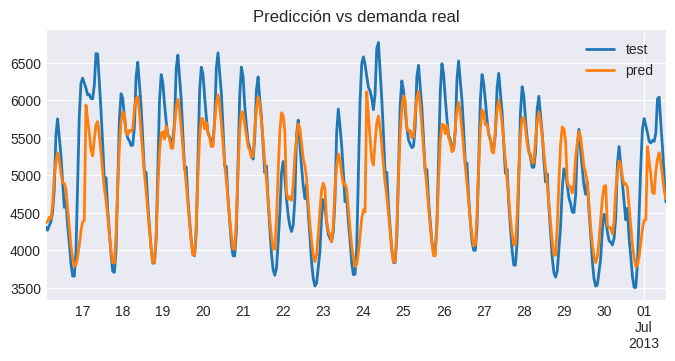

In [28]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [29]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 309.6070390467047


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 24, # Este valor será remplazado en el grid search
                 transformer_y = StandardScaler()
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                      forecaster         = forecaster,
                      y                  = datos.loc[:fin_validacion, 'Demand'],
                      steps              = 24,
                      metric             = 'mean_absolute_error',
                      param_grid         = param_grid,
                      lags_grid          = lags_grid,
                      initial_train_size = len(datos[:fin_train]),
                      refit              = False,
                      n_jobs             = 'auto',
                      return_best        = True,
                      verbose            = False
                  )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 27.825594022071257}
  Backtesting metric: 300.3613401940532



In [31]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lags,params,mean_absolute_error,alpha
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 27.825594022071257},300.361340,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 3.593813663804626},322.160718,3.593814
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 215.44346900318823},323.887466,215.443469
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},326.654888,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.05994842503189409},327.290720,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.007742636826811269},327.373926,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},327.384703,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},354.773124,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},354.777873,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},354.814643,0.059948


In [32]:
forecaster


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ForecasterAutoreg 
Regressor: Ridge(alpha=27.825594022071257) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2011-12-31 14:00:00'), Timestamp('2013-06-16 01:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 27.825594022071257, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-26 15:38:48 
Last fit date: 2023-10-26 15:39:44 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

  0%|          | 0/16 [00:00<?, ?it/s]

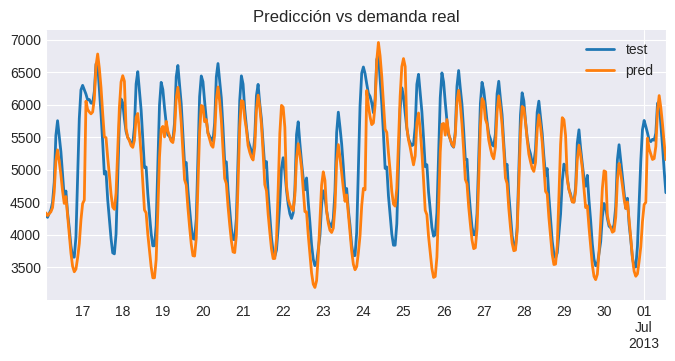

In [33]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['Demand'],
                            steps              = 24,
                            metric             = mean_absolute_error,
                            initial_train_size = len(datos[:fin_validacion]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [34]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 337.340994475359


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos['Demand'],
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            initial_train_size  = len(datos.loc[:fin_validacion]),
                            refit               = False,
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            n_jobs              = 'auto',
                            verbose             = False,
                            show_progress       = True
                        )

print('Métrica backtesting:', metrica)
predicciones.head(5)

  0%|          | 0/16 [00:00<?, ?it/s]

Métrica backtesting: 337.340994475359


,pred,lower_bound,upper_bound
2013-06-16 02:00:00,4338.735621,4227.994039,4437.144271
2013-06-16 03:00:00,4296.016359,4106.422815,4468.109816
2013-06-16 04:00:00,4325.593009,4088.886542,4524.941408
2013-06-16 05:00:00,4353.716650,4077.122185,4629.212106
2013-06-16 06:00:00,4418.762636,4080.500494,4743.680122


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


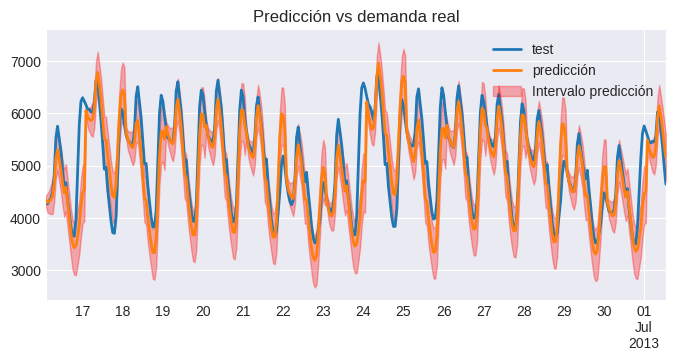

In [36]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción'
)
ax.legend();

In [37]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                       (datos.loc[fin_validacion:, 'Demand'] >= predicciones['lower_bound']) & \
                       (datos.loc[fin_validacion:, 'Demand'] <= predicciones['upper_bound']),
                       True,
                       False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

Cobertura del intervalo predicho: 73.66 %


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Final de initial_train_size + 12 posiciones
# ==============================================================================
datos.iloc[:len(datos.loc[:fin_validacion])+12].tail(2)

,Demand,Temperature,Holiday,mes,dia_semana,hora_dia
Time,,,,,,
2013-06-16 12:00:00,4917.380568,9.75,0.0,6,7,13
2013-06-16 13:00:00,4575.020736,9.45,0.0,6,7,14


In [39]:
# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            n_jobs                = 'auto',
                            verbose               = True,
                            show_progress         = True
                        )

print("")
print('Métrica backtesting:', metrica)
predicciones.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12792
Number of observations used for backtesting: 360
    Number of folds: 15
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 12
    Last fold only includes 12 observations.

Fold: 0
    Training:   2011-12-31 14:00:00 -- 2013-06-16 13:00:00  (n=12792)
    Validation: 2013-06-17 02:00:00 -- 2013-06-18 01:00:00  (n=24)
Fold: 1
    Training:   2011-12-31 14:00:00 -- 2013-06-16 13:00:00  (n=12792)
    Validation: 2013-06-18 02:00:00 -- 2013-06-19 01:00:00  (n=24)
Fold: 2
    Training:   2011-12-31 14:00:00 -- 2013-06-16 13:00:00  (n=12792)
    Validation: 2013-06-19 02:00:00 -- 2013-06-20 01:00:00  (n=24)
Fold: 3
    Training:   2011-12-31 14:00:00 -- 2013-06-16 13:00:00  (n=12792)
    Validation: 2013-06-20 02:00:00 -- 2013-06-21 01:00:00  (n=24)
Fold: 4
    Training:   2011-12-31 14:00:00 -- 2013-06-16 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/15 [00:00<?, ?it/s]


Métrica backtesting: 449.52730056870746


,pred
2013-06-17 02:00:00,4476.063786
2013-06-17 03:00:00,4437.493444
2013-06-17 04:00:00,4483.096866
2013-06-17 05:00:00,4533.013603
2013-06-17 06:00:00,4635.773011


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


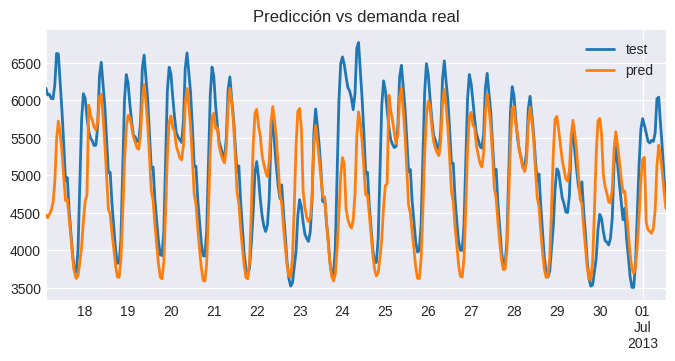

In [40]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [41]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 449.52730056870746


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Importancia predictores
# ==============================================================================
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,importance
0,lag_1,1.124201
1,lag_2,-0.132539
2,lag_3,-0.035233
3,lag_23,0.108111
4,lag_24,0.465671
5,lag_25,-0.567744
6,lag_47,-0.100576
7,lag_48,0.294826
8,lag_49,-0.185998


In [43]:
# Se convierte la columna Holiday de boolean a integer
# ==============================================================================
datos['Holiday'] = datos['Holiday'].astype(int)
datos_train['Holiday'] = datos_train['Holiday'].astype(int)
datos_test['Holiday'] = datos_test['Holiday'].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(alpha=215.44, random_state=123),
                 lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'], exog=datos.loc[:fin_validacion, 'Holiday'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2011-12-31 14:00:00'), Timestamp('2013-06-16 01:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-26 15:40:25 
Last fit date: 2023-10-26 15:40:25 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [45]:
# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            exog                  = datos['Holiday'],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True
                        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


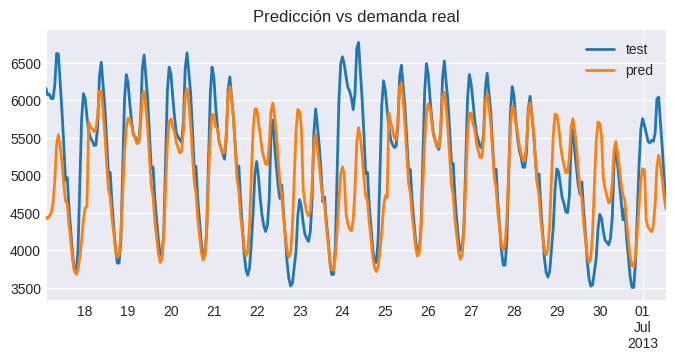

In [46]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [47]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 426.8729224876444


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Creación de nuevas variables exógenas
# ==============================================================================
# Al ser datos  horarios y empezar a las 00:00 se tienen que desplazar los valores
# de 24 en 24.
datos['Holiday_day_before'] = datos['Holiday'].shift(24)
datos['Holiday_next_day']   = datos['Holiday'].shift(-24)
datos = datos.dropna()

# One hot encoding del día de la semana y la hora del día
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          ['dia_semana', 'hora_dia'],
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

datos = one_hot_encoder.fit_transform(datos)
datos.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,dia_semana_7,hora_dia_1,hora_dia_2,hora_dia_3,...,hora_dia_21,hora_dia_22,hora_dia_23,hora_dia_24,Demand,Temperature,Holiday,mes,Holiday_day_before,Holiday_next_day
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4265.965213,21.500,1,1,1.0,0.0
2012-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3825.128319,21.075,1,1,1.0,0.0
2012-01-01 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3858.743655,20.625,1,1,1.0,0.0


In [49]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44, random_state=123),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )

exog = [column for column in datos.columns if column.startswith(('dia', 'hora', 'Holiday'))]
forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'], exog=datos.loc[:fin_validacion, exog])

# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            exog                  = datos[exog],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True
                        )

# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print("")
print(f"Error de backtest: {error}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/14 [00:00<?, ?it/s]


Error de backtest: 334.36742631081404
